# Fitting a GP Kernel to a dataset then sampling $N$ test points

In [1]:
# !pip uninstall -y gpytorch torch torchvision torchaudio
# !pip cache remove "*"
# !pip install torch gpytorch
import torch
import gpytorch

torch.__version__, gpytorch.__version__

('2.1.1+cu121', '1.11')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import numpy as np
import scipy as scp
import pandas as pd
from tqdm import trange

In [4]:
!pip install --quiet contextily rasterio
import geopandas as gpd
from shapely.geometry import box, Point
import contextily as cx
import rasterio as rio

In [5]:
%matplotlib widget
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [6]:
mask = box(minx=186130.,miny=618842.5,maxx=206925.5,maxy=652393.) # Isle of Arran in EPSG:27700
gdf = gpd.read_file("smr_pls.gpkg", mask=mask)
gdf

Activity    Age                       geometry
0    Hillwalking (winter)  26-35  POINT (199432.894 638908.006)
1    Hillwalking (winter)  17-25  POINT (199432.894 638908.006)
2                    None   None  POINT (199833.834 639507.950)
3                    None   None  POINT (200535.696 638207.834)
4           Cycling (any)   0-16  POINT (200535.715 638007.833)
..                    ...    ...                            ...
156  Hillwalking (summer)  36-45  POINT (199633.169 641207.993)
157  Hillwalking (summer)  36-45  POINT (199633.169 641207.993)
158  Hillwalking (summer)   0-16  POINT (199131.888 641508.072)
159                  None  56-65  POINT (199933.956 640807.944)
160  Hillwalking (summer)  26-35  POINT (199833.688 641007.961)

[161 rows x 3 columns]

## Dataset

In [7]:
def gen_bivariate_normal(n, scale=3,min_mean=-10, max_mean=10):
    cov = np.eye(2)*scale*(0.2+np.random.rand())    
    mean =  np.random.randint(min_mean,max_mean, (2,))
    return np.random.multivariate_normal(mean, cov, n)

def make_range(pts):
    return ((pts[:,0].min(),pts[:,0].max()),(pts[:,1].min(),pts[:,1].max()))

N = 20

def make_hist(data,r = None, bins = (N,N)):
    return np.histogram2d(data[:,0], data[:,1], range=r if r is not None else make_range(data),density=True, bins=bins)

pts = np.vstack([gdf.geometry.x,gdf.geometry.y]).T
minx,miny,maxx,maxy = mask.bounds

data = make_hist(pts, [[minx,maxx],[miny,maxy]])[0]

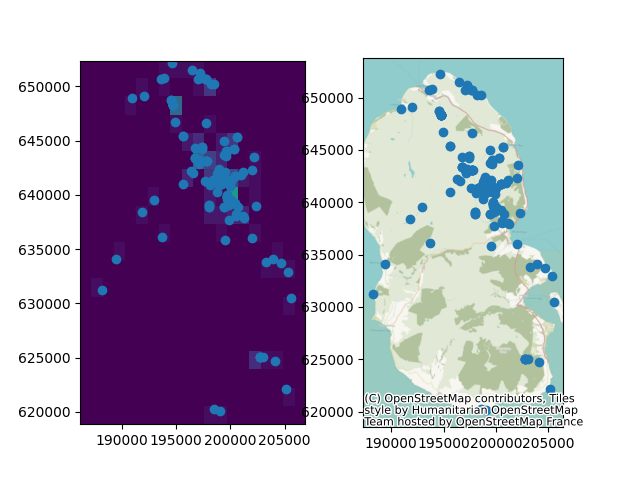

In [8]:
fig, ax = plt.subplots(1,2)

minx,miny,maxx,maxy = mask.bounds
extent = [minx,maxx,miny,maxy]

ax[0].imshow(data.T, extent=[minx,maxx,miny,maxy], origin='lower')
gdf.plot(ax=ax[0])

gdf.plot(ax=ax[1])
cx.add_basemap(ax[1], crs=gdf.crs)

plt.show()

## Set up training data

In [9]:
xv, yv = torch.meshgrid(torch.linspace(0,1,N), torch.linspace(0,1, N), indexing="ij")

train_x = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1
).double()


train_y = torch.hstack([torch.from_numpy(data.ravel())]).double()
train_y = (train_y-train_y.min())/(train_y.max()-train_y.min())

## Setting up the model

In [10]:
class GridRegressionsGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GridRegressionsGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.base_kernel = gpytorch.kernels.MaternKernel(ard_num_dims=2)
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(gpytorch.kernels.ScaleKernel(self.base_kernel), grid_size=grid_size,num_dims=2)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GridRegressionsGPModel(train_x, train_y,likelihood)

In [11]:
if torch.cuda.is_available():
    train_x = train_x.cuda()
    train_y = train_y.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()
    
train_x = train_x.double()
train_y = train_y.double()
model = model.double()
likelihood = likelihood.double()

## Train the model

In [12]:
training_iter = 250

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [13]:
model.train()
likelihood.train()

losses = []
pbar = trange(training_iter)
sample_step_size = np.max([1,training_iter//100_000])
for i in pbar:
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    
    if i%sample_step_size == 0:
        pbar.set_description(f"Iter {i + 1:d}/{training_iter:d} - Loss: {loss.item():.3f}")
    if i%sample_step_size == 0:
        losses.append((i,loss.item()))

    optimizer.step()

  0%|                                                                                           | 0/250 [00:00<?, ?it/s]/opt/miniconda3/envs/jpathgen/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
/opt/miniconda3/envs/jpathgen/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
Iter 250/250 - Loss: -1.394: 100%|███████████

## Plot

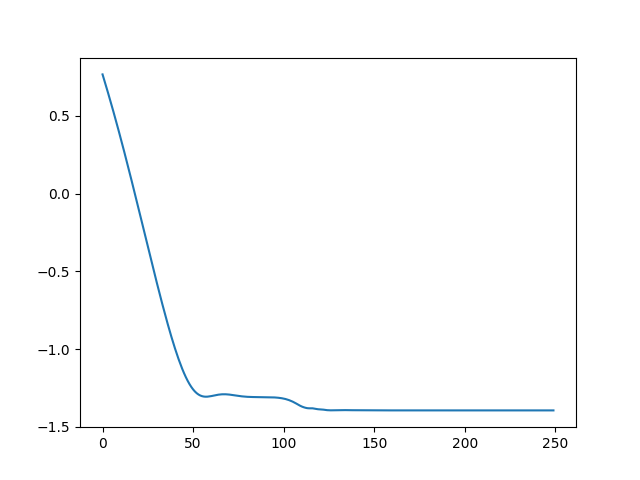

In [14]:
fig, ax = plt.subplots()
losses_np = np.array(losses)

ax.plot(losses_np[:,0], losses_np[:,1])

In [15]:
if torch.cuda.is_available():
    # Set to CPU mode
    model = model.cpu()
    likelihood = likelihood.cpu()
    train_x = train_x.cpu()
    train_y = train_y.cpu()

In [16]:
    
# Set into eval mode
model.eval()
likelihood.eval()


multiplier = 5
xv,yv = torch.meshgrid(torch.linspace(0,1, (N)*multiplier), torch.linspace(0,1, (N)*multiplier), indexing="ij")

# Test points
f = data

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    test_x = torch.stack([xv.ravel(), yv.ravel()], -1).squeeze(1).double()
    predictions = likelihood(model(test_x))

In [20]:
mean_pred = predictions.mean
stddev_pred = predictions.stddev

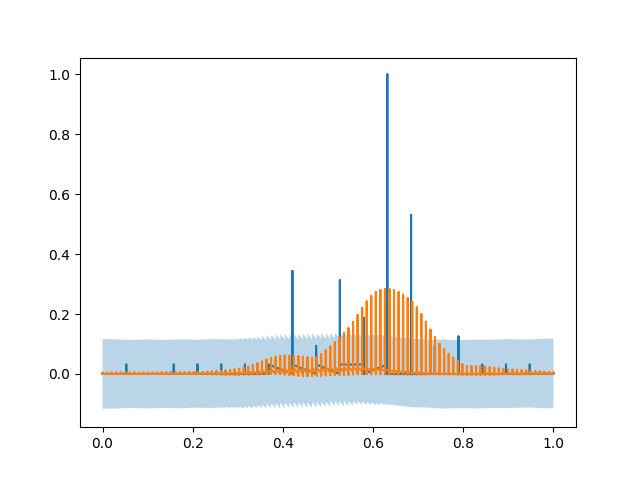

In [21]:
fig, ax = plt.subplots()
mean_pred_np = mean_pred.numpy()
# p = (mean_pred_np+np.abs(mean_pred_np.min()))
# p /= p.sum()
lower, upper = predictions.confidence_region()
ax.fill_between(test_x[:,0],lower.numpy(), upper.numpy(),alpha=0.3)
ax.plot(train_x[:,0], train_y)
ax.plot(test_x[:,0], predictions.mean.numpy())

plt.show()

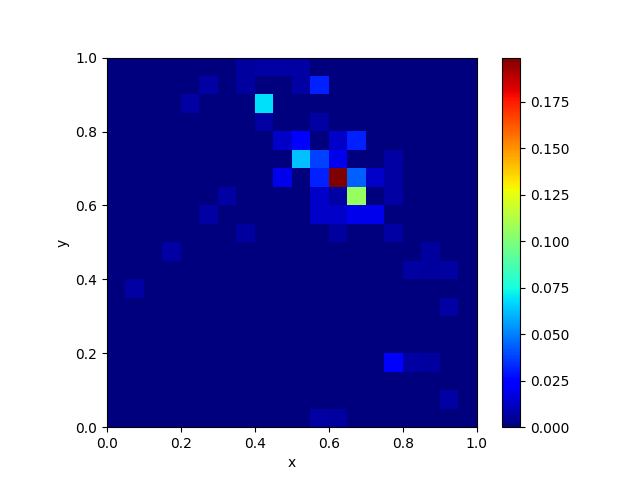

In [22]:
# Initialize plots
fig, ax = plt.subplots(1,1)


cb = ax.imshow(f.T/np.sum(f), extent=[0,1,0,1], origin='lower', cmap=cm.jet)
ax.set_ylabel("y")
fig.colorbar(cb)
ax.set_xlabel("x")
plt.show()

fig.savefig("pls_raw_data_heatmap.pdf")

In [23]:
(mean_pred_np+np.abs(mean_pred_np.min())).size

10000

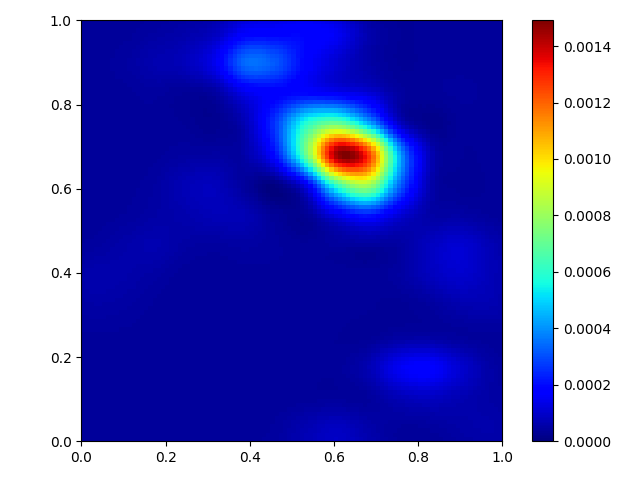

In [24]:
fig, ax = plt.subplots(1,1)

mean_pred_np = mean_pred.numpy()
p = (mean_pred_np+np.abs(mean_pred_np.min()))
p /= p.sum()
ind = np.random.choice(np.arange(mean_pred_np.size), p = p,size=1000)
unique, counts = np.unique(ind, return_counts=True)
pim = p.reshape((int(np.sqrt(p.size)),-1)).T
cb =ax.imshow(p, extent=[0,1,0,1], origin='lower', cmap=cm.jet)
# ax.scatter(test_x[unique][:,0],test_x[unique][:,1],s=counts,c='w',label='Samples')
fig.colorbar(cb)
fig.tight_layout()

plt.show()

fig.savefig("pls_gp_sampled_heatmap.pdf")

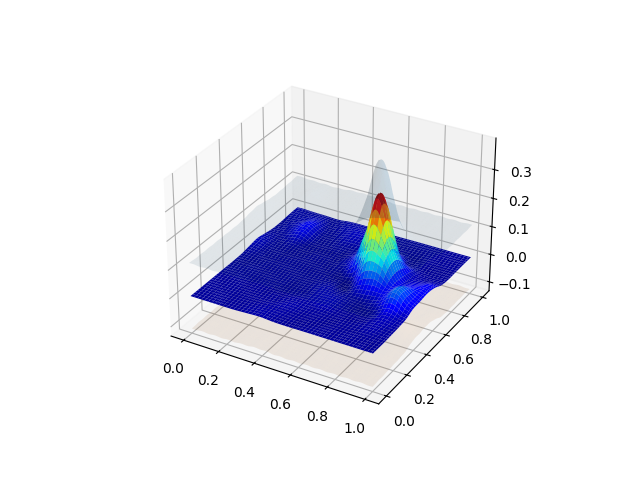

In [25]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(xv,yv, mean_pred_np.reshape((int(np.sqrt(p.size)),-1)).T,cmap=cm.jet,)

ax.plot_surface(xv,yv,(mean_pred_np+2*stddev_pred.detach().numpy()).reshape((int(np.sqrt(p.size)),-1)).T, alpha=0.1)
ax.plot_surface(xv,yv,(mean_pred_np-2*stddev_pred.detach().numpy()).reshape((int(np.sqrt(p.size)),-1)).T, alpha=0.1)

In [26]:
doe_pts_ind = np.random.choice(np.arange(mean_pred_np.size), p = p,size=1000)
doe_pts = test_x[doe_pts_ind].detach().numpy()

ValueError: 'p' must be 1-dimensional

In [ ]:
trans = rio.transform.from_bounds(minx,maxy,maxx,miny, width=1,height=1)
trans

In [ ]:
doe_pts_df = gpd.GeoDataFrame({'geometry': [Point(f,g) for f,g in doe_pts]}).affine_transform(trans.to_shapely()).set_crs(epsg=27700)

ax = doe_pts_df.plot(figsize=(6.5, 9))
cx.add_basemap(ax, crs=doe_pts_df.crs)
ax = plt.gca()
ax.set_ylabel("y")
ax.set_xlabel("x")
fig = plt.gcf()
fig.tight_layout()
plt.show()
fig.savefig(f"pls_{len(doe_pts_df)}_sampled_points_over_arran.pdf")

In [ ]:
with open("starting_points.txt", "w") as f:
    f.write(" ".join(map(lambda i: f"{i[0]:.4f},{i[1]:.4f}", zip(doe_pts_df.geometry.x,doe_pts_df.geometry.y))))

## Upsampling using other, perhaps faster, methods

In [ ]:
from PIL import Image

In [ ]:
im = Image.fromarray(f.T/np.sum(f))
width, height = im.size

In [ ]:
im_lanczos = im.resize((100,100), resample=Image.Resampling.LANCZOS)

In [ ]:
# Initialize plots

for resample in [Image.Resampling.BICUBIC, Image.Resampling.LANCZOS]:
    fig, ax = plt.subplots(1,1)
    
    cb = ax.imshow(np.array(im.resize((100,100), resample=resample)), extent=[0,1,0,1], origin='lower', cmap=cm.jet)
    ax.set_ylabel("y")
    fig.colorbar(cb)
    ax.set_xlabel("x")
    plt.show()
    
    fig.savefig(f"pls_{resample.name.lower()}_sampled_heatmap.pdf")